In [1]:
import json
from random import shuffle
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score,confusion_matrix

In [2]:
import nltk
from nltk import word_tokenize
from nltk.classify import SklearnClassifier
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.corpus import stopwords
from collections import Counter
import numpy
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from collections import Counter
from sklearn.feature_extraction import DictVectorizer
from scipy import sparse
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from sklearn import decomposition, ensemble
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns
from nltk.stem import WordNetLemmatizer 
import spacy
from spacy import displacy
from collections import Counter
from pprint import pprint
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import metrics

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Import Data

In [5]:
top_char=20

In [6]:
# Read JSON scripts into dataframe
df=pd.read_json('data/dialogues-combined.json')
df.columns=['script_number','scene','character','dialogue','attributes','char_groups']
df['scene']=df['scene'].str.split('|')

In [7]:
# Select most frequent characters
x=df.character.value_counts().head(top_char).keys()
df=df.loc[df['character'].isin(x)]
df=df.reset_index(drop=True)

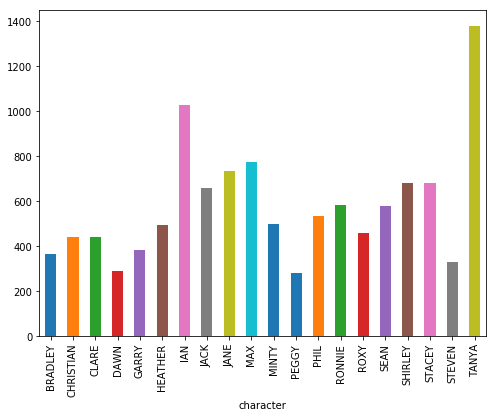

In [8]:
# Plot count of dialogues
fig = plt.figure(figsize=(8,6))
df.groupby('character').dialogue.count().plot.bar(ylim=0)
plt.show()

In [9]:
# Add Gender Heuristic to the data
gender_df = pd.read_csv('data/gender.csv',na_filter=False)
gender_dict=dict(zip(gender_df.name, gender_df.gender))
df['gender']=df['character'].apply(lambda x: 'unknown' if gender_dict.get(x,'') =='' else  gender_dict[x])

In [10]:
# Label encoding
encoder = preprocessing.LabelEncoder()
char = encoder.fit_transform(df['character'])
#df = df.drop('character', axis=1)
df['category_id']=char
labels = df.category_id

#create an ordered mapping between character and category_id
category_df = df[['character', 'category_id']].drop_duplicates().sort_values('category_id')

In [11]:
# preview dataset
df.head()

,script_number,scene,character,dialogue,attributes,char_groups,gender,category_id
0,1350,"[DESERTED CAR PARK, EXT, NIGHT]",SHIRLEY,"Look at ya, not a mark on ya. And you think yo...",[],"[KEVIN, SHIRLEY]",female,16
1,1350,"[R&R, INT, NIGHT]",JACK,Oi. Where have you been? Huh? What were the te...,[],"[JACK, RONNIE]",male,7
2,1350,"[R&R, INT, NIGHT]",RONNIE,Nothing. Nothing. I'll be with you in two minu...,[],"[JACK, RONNIE]",female,13
3,1350,"[R&R, INT, NIGHT]",JACK,Well I've got mates here I wanted to have a ch...,[],"[JACK, RONNIE]",male,7
4,1350,"[R&R, INT, NIGHT]",RONNIE,Alright. Two minutes.,[],"[JACK, RONNIE]",female,13


# Feature Engineering

#### Text preprocessing Function

In [12]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

#### Non-Textual Features

In [13]:
# Method to parse attributes into dictionary
def parseAttribures(attr):
    if attr is None:
        return None
    else:
        return dict((x,attr.count(x)) for x in set(attr))


#Scene Details as features
f_scene=DictVectorizer().fit_transform(df['scene'].apply(parseAttribures)) 

# Script's parenthetical attributes as features
f_attributes=DictVectorizer().fit_transform(df['attributes'].apply(parseAttribures)) 
max_abs_scaler = preprocessing.MaxAbsScaler()
f_attributes_scaled = max_abs_scaler.fit_transform(f_attributes)   # parenthetical attributes as features  - SCALED


# Top 100 Character groups as features
top_char_groups=list(df['char_groups'].apply('|'.join).value_counts().head(100).keys())
f_char_groups=DictVectorizer().fit_transform(df['char_groups'].apply('|'.join).apply(lambda x: x  if x  in top_char_groups else 'UNKNOWN').apply(lambda x:[x]).apply(parseAttribures))

# Gender as a Feature
f_gender=DictVectorizer().fit_transform(df['gender'].apply(lambda x:[x]).apply(parseAttribures))


#### Text Metadata features

In [14]:
def extractMeta(x):
    return {'count_chars': len(x),
            'count_whitespace': x.count(" "),
            'count_dots': x.count(".")-3*(x.count("...")),
            'count_cdots': x.count("..."),
            'count_excl': x.count("!"),
            'count_ques': x.count("?"),
            'count_num': len(re.findall("\d", x)),
            'count_upper': len(re.findall("[A-Z]", x)),
            'count_words': len(x) / (x.count(" ") + 1),
            'count_sent': x.count(" ") / (x.count(".") + 1)           
           }
f_meta=DictVectorizer().fit_transform(df['dialogue'].apply(extractMeta))

max_abs_scaler = preprocessing.MaxAbsScaler()
f_meta_scaled = max_abs_scaler.fit_transform(f_meta)  # Metadata features scaled

#### N-gram counts and frequencies

In [15]:
#Count Vectors
count_vect = CountVectorizer(analyzer='word', stop_words='english',token_pattern=r'\w{1,}')
f_count=count_vect.fit_transform(df['dialogue'])

#TF-IDF unigram
tfidf_vect = TfidfVectorizer(analyzer='word',token_pattern=r"\b\w[\w']+\b", tokenizer=LemmaTokenizer(),max_features=5000)
f_tfidf=tfidf_vect.fit_transform(df['dialogue'])

#TF-IDF n-gram
tfidf_ngram_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
f_tfidf_ngram=tfidf_ngram_vect.fit_transform(df['dialogue'])

#TF-IDF char n-gram
tfidf_ngram_chars_vect = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
f_tfidf_ngram_chars=tfidf_ngram_chars_vect.fit_transform(df['dialogue'])


#### POS Tags

In [16]:
from nltk.tag import CRFTagger
import pycrfsuite
tokenizer = RegexpTokenizer(r'\w+')

TAGGER_PATH = "data/crfpostagger"   # pre-trained POS-tagger 
tagger = CRFTagger()  
tagger.set_model_file(TAGGER_PATH)

pos_tags=tagger.tag_sents([word.lower() for word in s] for s in df['dialogue'].apply(tokenizer.tokenize))
pos_tags_str = []
for word in pos_tags:
    pos_tags_con=[w[0]+'_'+w[1] for w in word]
    pos_tags_str.append(' '.join(pos_tags_con))
tfidf_pos = TfidfVectorizer(lowercase=False,max_features=5000)
f_pos_tags=tfidf_pos.fit_transform(pos_tags_str)

#### POS Tags a metadata features

In [17]:
pos_family = {
    'noun' : ['NN','NNS','NNP','NNPS'],
    'pron' : ['PRP','PRP$','WP','WP$'],
    'verb' : ['VB','VBD','VBG','VBN','VBP','VBZ'],
    'adj' :  ['JJ','JJR','JJS'],
    'adv' : ['RB','RBR','RBS','WRB']
}

In [18]:
####### count of each POS type 
def check_pos_tag(x, flag):
    cnt = 0
    try:
        for tup in x:
            ppo = list(tup)[1]
            if ppo in pos_family[flag]:
                cnt += 1
    except:
        pass
    return cnt


def extractPOS(x):
    count_noun=check_pos_tag(x,'noun')
    count_verb=check_pos_tag(x,'verb')
    count_adj=check_pos_tag(x,'adj')
    count_adv=check_pos_tag(x,'adv')
    count_pron=check_pos_tag(x,'pron')
    count_sum=count_noun+count_verb+count_adj+count_adv+count_pron+1
    return {'count_noun': count_noun/count_sum,
            'count_verb': count_verb/count_sum,
            'count_adj': count_adj/count_sum,
            'count_adv': count_adv/count_sum,
            'count_pron': count_pron/count_sum,
           }
f_pos_count=DictVectorizer().fit_transform(df['dialogue'].apply(tokenizer.tokenize).apply(lambda x: [word.lower() for word in x]).apply(tagger.tag).apply(extractPOS))


#### Topic Modelling

In [19]:
# train a LDA Model

#tm_vect = TfidfVectorizer(analyzer='word',token_pattern=r"\b\w[\w']+\b",stop_words='english', max_features=5000)
tm_vect = CountVectorizer(analyzer='word', stop_words='english',token_pattern=r"\b\w[\w']+\b")

f_tm=tm_vect.fit_transform(df['dialogue'])


lda_model = decomposition.LatentDirichletAllocation(n_components=20, learning_method='online', max_iter=20)
f_topics = lda_model.fit_transform(f_tm)

In [20]:
# Preview the topic words
topic_word = lda_model.components_ 
vocab = tm_vect.get_feature_names()

# view the topic models
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topic_word):
    topic_words = numpy.array(vocab)[numpy.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append('|'.join(topic_words))
pprint(topic_summaries)

["little|er|jane|we'll|ask|problem|abi|hope|aren't|heather",
 "going|can't|thanks|sean|wanted|coming|hazel|minute|tomorrow|wants",
 "i'd|tanya|best|long|new|happy|used|clare|probably|oscar",
 "just|we're|it's|love|mum|talk|they're|gonna|great|suppose",
 "want|he's|night|say|don't|eh|home|listen|we've|it's",
 "yeah|you're|that's|it's|just|max|thing|away|gonna|cause",
 "know|don't|really|said|day|dad|you'd|it's|life|wanna",
 "i'll|time|need|good|way|getting|it's|work|wouldn't|having",
 'better|stop|lucy|saying|big|party|job|bye|ben|watch',
 "come|won't|leave|don't|nice|you'll|chance|christian|bad|stupid",
 "phil|stay|minty|he'll|lauren|shirl|cheers|nah|pay|went",
 "gotta|girls|oi|sort|actually|weren't|ronnie|innit|who's|saw",
 "alright|oh|yes|gonna|it's|ya|help|house|seen|steven",
 "got|i've|tell|kids|there's|haven't|drink|jack|gonna|money",
 "like|look|let|told|mate|don't|babe|hello|man|trust",
 "mean|didn't|doing|you've|bit|thought|maybe|things|know|got",
 "i'm|sorry|taking|yesterday|s

#### Named Entity Recognition

In [21]:
spacy_nlp = spacy.load('en')

doc = df['dialogue'].apply(spacy_nlp).apply(lambda x : [X.label_ for X in x.ents])
def getCountNER(attr):
    return dict((x,attr.count(x)) for x in set(attr))
f_ner=DictVectorizer().fit_transform(doc.apply(getCountNER))  # Number of each type of named entity -> as a feature

#### Sentiment

In [22]:
nltk.download('vader_lexicon')
sia = SIA()
sentiment= df['dialogue'].apply(sia.polarity_scores)
f_sent=DictVectorizer().fit_transform(df['dialogue'].apply(sia.polarity_scores)) #Sentiment polarity score as feature
min_max_scaler = preprocessing.MinMaxScaler()
f_sent_scaled = min_max_scaler.fit_transform(f_sent.toarray()) # Sentiment features scaled

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pankaj/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Text Classification

In [23]:
# Define classifiers to be evaluated

# Define feature selector
feature_selector=SelectKBest(chi2, k=1000)

#Create pipelines for each classifier type
svm_pipeline = Pipeline([('chi2', feature_selector),('svm', LinearSVC())])
nb_pipeline = Pipeline([('chi2', feature_selector),('nb', MultinomialNB())])
lr_pipeline = Pipeline([('chi2', feature_selector),('lr', LogisticRegression())])

# Create classifier list
models = [
    OneVsRestClassifier(svm_pipeline),
    OneVsRestClassifier(nb_pipeline),
    OneVsRestClassifier(lr_pipeline)
]
model_names=['SVM', 'Naive-Bayes','Max-Entropy']

In [24]:
# cross validation function
def cross_validation(features,labels, fold):
    cv_df = pd.DataFrame(index=range(fold * len(models)))
    entries = []
    for model,model_name in zip(models,model_names):
        accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=fold)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    return cv_df

### 1. Only Textual Features

In [25]:
# Combining Features
features=sparse.hstack([f_tfidf,f_topics,f_pos_tags,f_ner,f_meta_scaled,f_pos_count,f_sent_scaled])


In [26]:
# Split data into train and test - 90% train, 10% test
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.1, random_state=0)

#### Model evaluation via cross validation

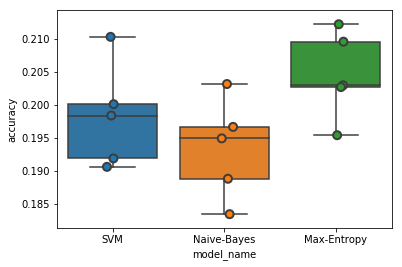

In [27]:
# Training and Cross Validation
fold=5
cv_df=cross_validation(X_train,y_train, fold)

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [28]:
print('Training/Cross validation average accuracies: ')
cv_df.groupby('model_name').accuracy.mean()

Training/Cross validation average accuracies: 


model_name
Max-Entropy    0.204561
Naive-Bayes    0.193384
SVM            0.198245
Name: accuracy, dtype: float64

#### Testing the best model

In [29]:
model=OneVsRestClassifier(svm_pipeline)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc=accuracy_score(y_test, y_pred)
print('Test Accuracy: ', acc)
print('\n\n')
print(metrics.classification_report(y_test, y_pred, target_names=category_df.character.values))

Test Accuracy:  0.17728055077452667



              precision    recall  f1-score   support

     BRADLEY       0.00      0.00      0.00        38
   CHRISTIAN       0.07      0.05      0.06        40
       CLARE       0.03      0.02      0.02        45
        DAWN       0.13      0.17      0.15        24
       GARRY       0.16      0.10      0.12        42
     HEATHER       0.26      0.20      0.23        50
         IAN       0.24      0.21      0.22       112
        JACK       0.13      0.13      0.13        52
        JANE       0.32      0.27      0.29        67
         MAX       0.20      0.24      0.22        79
       MINTY       0.07      0.07      0.07        42
       PEGGY       0.16      0.17      0.16        36
        PHIL       0.11      0.08      0.09        60
      RONNIE       0.16      0.15      0.16        52
        ROXY       0.13      0.14      0.14        42
        SEAN       0.16      0.15      0.15        60
     SHIRLEY       0.20      0.14      0.1

#### Confusion Matrix

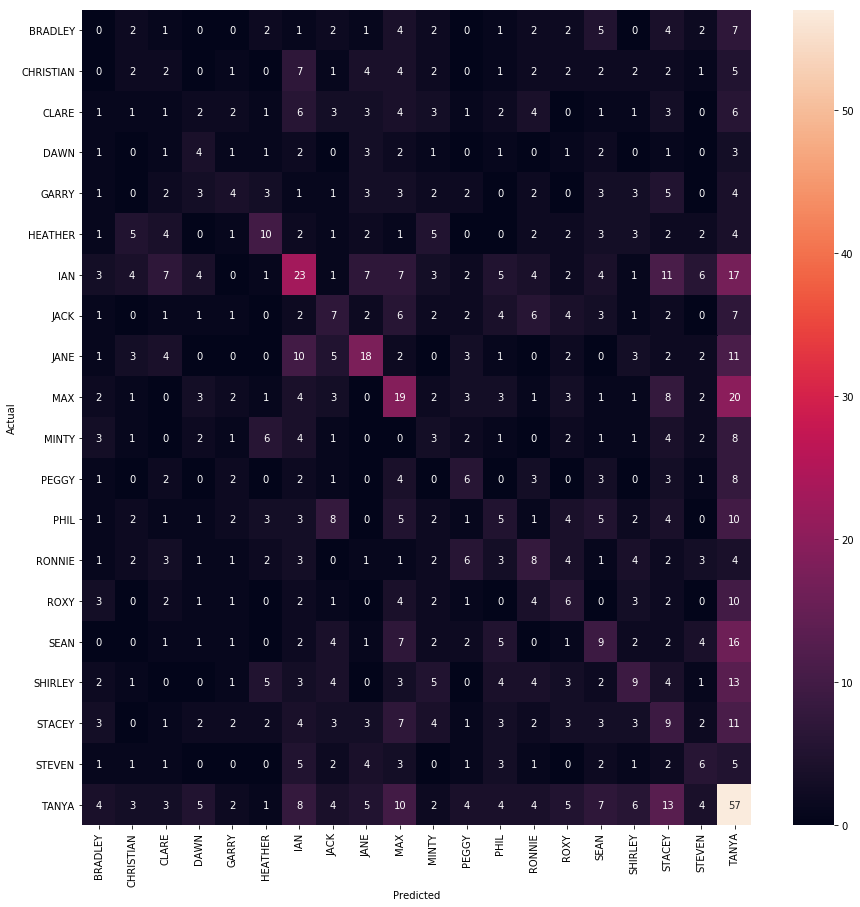

In [30]:
#Plotting the classifiaction matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_df.character.values, yticklabels=category_df.character.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 2. Textual Features with Scene details and Parenthetical Attributes

In [31]:
# Combining Features
features=sparse.hstack([f_tfidf,f_topics,f_pos_tags,f_ner,f_meta_scaled,f_pos_count,f_sent_scaled,f_attributes_scaled,f_scene])


In [32]:
# Split data into train and test - 90% train, 10% test
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.1, random_state=0)

#### Model evaluation via cross validation

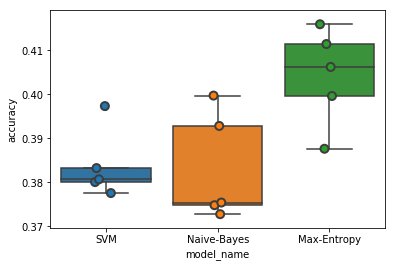

In [33]:
# Training and Cross Validation
fold=5
cv_df=cross_validation(X_train,y_train, fold)

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [34]:
print('Training/Cross validation average accuracies: ')
cv_df.groupby('model_name').accuracy.mean()

Training/Cross validation average accuracies: 


model_name
Max-Entropy    0.404163
Naive-Bayes    0.383112
SVM            0.383786
Name: accuracy, dtype: float64

#### Testing the best model

In [35]:
model=OneVsRestClassifier(svm_pipeline)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc=accuracy_score(y_test, y_pred)
print('Test Accuracy: ', acc)
print('\n\n')
print(metrics.classification_report(y_test, y_pred, target_names=category_df.character.values))

Test Accuracy:  0.3812392426850258



              precision    recall  f1-score   support

     BRADLEY       0.38      0.32      0.34        38
   CHRISTIAN       0.22      0.10      0.14        40
       CLARE       0.28      0.24      0.26        45
        DAWN       0.35      0.38      0.36        24
       GARRY       0.48      0.24      0.32        42
     HEATHER       0.29      0.22      0.25        50
         IAN       0.46      0.51      0.48       112
        JACK       0.33      0.33      0.33        52
        JANE       0.45      0.40      0.43        67
         MAX       0.42      0.35      0.38        79
       MINTY       0.26      0.33      0.29        42
       PEGGY       0.32      0.33      0.32        36
        PHIL       0.36      0.27      0.30        60
      RONNIE       0.21      0.23      0.22        52
        ROXY       0.27      0.36      0.31        42
        SEAN       0.27      0.20      0.23        60
     SHIRLEY       0.40      0.48      0.44

#### Confusion Matrix

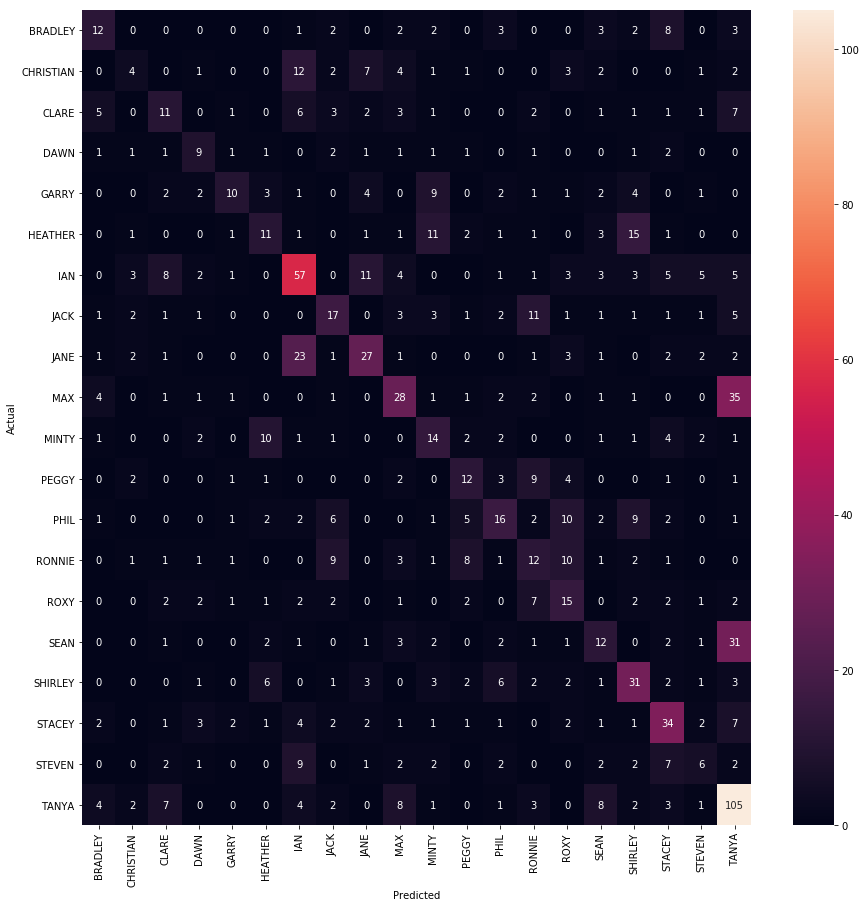

In [36]:
#Plotting the classifiaction matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_df.character.values, yticklabels=category_df.character.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 3. Textual Features with Scene details,  Parenthetical Attributes and character groups

In [37]:
# Combining Features
features=sparse.hstack([f_tfidf,f_topics,f_pos_tags,f_ner,f_meta_scaled,f_pos_count,f_sent_scaled,f_attributes_scaled,f_scene,f_char_groups])


In [38]:
# Split data into train and test - 90% train, 10% test
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.1, random_state=0)

#### Model evaluation via cross validation

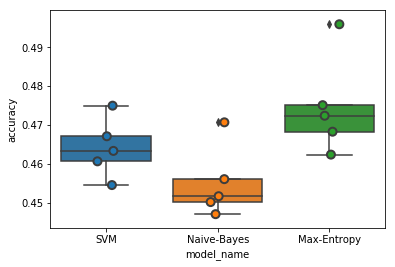

In [39]:
# Training and Cross Validation
fold=5
cv_df=cross_validation(X_train,y_train, fold)

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [40]:
print('Training/Cross validation average accuracies: ')
cv_df.groupby('model_name').accuracy.mean()

Training/Cross validation average accuracies: 


model_name
Max-Entropy    0.474828
Naive-Bayes    0.455134
SVM            0.464130
Name: accuracy, dtype: float64

#### Testing the best model

In [41]:
model=OneVsRestClassifier(svm_pipeline)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc=accuracy_score(y_test, y_pred)
print('Test Accuracy: ', acc)
print('\n\n')
print(metrics.classification_report(y_test, y_pred, target_names=category_df.character.values))

Test Accuracy:  0.4457831325301205



              precision    recall  f1-score   support

     BRADLEY       0.34      0.32      0.33        38
   CHRISTIAN       0.21      0.15      0.17        40
       CLARE       0.41      0.40      0.40        45
        DAWN       0.64      0.58      0.61        24
       GARRY       0.57      0.38      0.46        42
     HEATHER       0.40      0.32      0.36        50
         IAN       0.50      0.51      0.50       112
        JACK       0.36      0.48      0.41        52
        JANE       0.41      0.39      0.40        67
         MAX       0.44      0.43      0.44        79
       MINTY       0.39      0.43      0.41        42
       PEGGY       0.42      0.44      0.43        36
        PHIL       0.36      0.33      0.34        60
      RONNIE       0.30      0.29      0.29        52
        ROXY       0.37      0.50      0.42        42
        SEAN       0.45      0.42      0.43        60
     SHIRLEY       0.51      0.55      0.53

#### Confusion Matrix

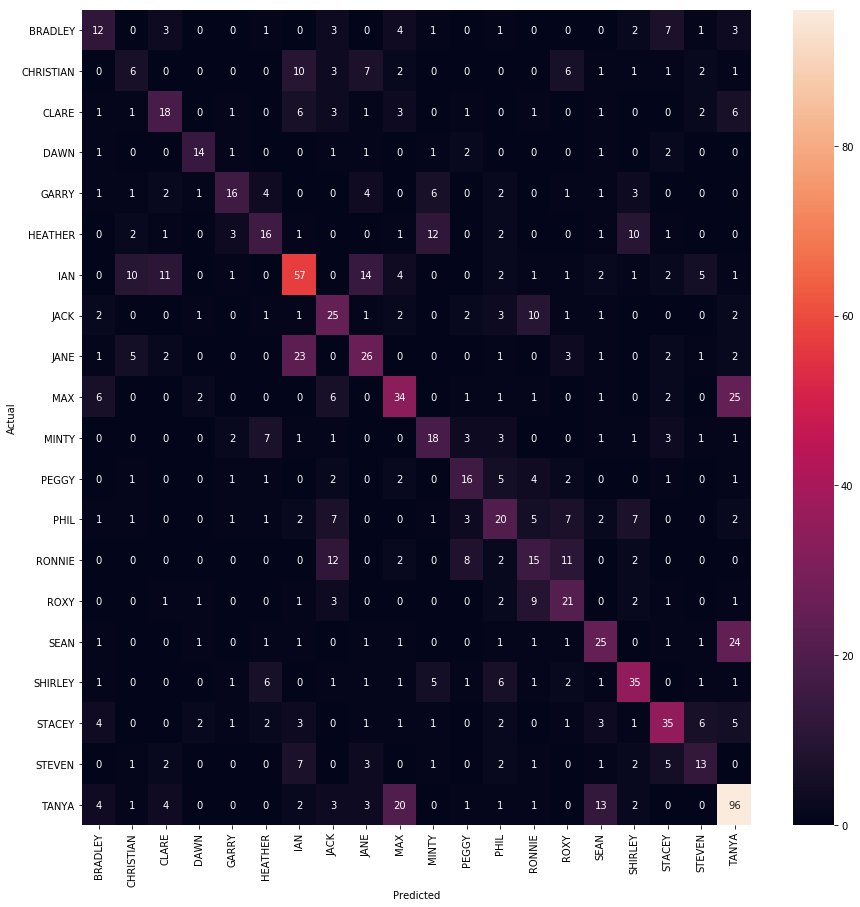

In [42]:
#Plotting the classifiaction matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_df.character.values, yticklabels=category_df.character.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 4. Textual Features with Scene details,  Parenthetical Attributes and character groups and gender

In [43]:
# Combining Features
features=sparse.hstack([f_tfidf,f_topics,f_pos_tags,f_ner,f_meta_scaled,f_pos_count,f_sent_scaled,f_attributes_scaled,f_scene,f_char_groups, f_gender])


In [44]:
# Split data into train and test - 90% train, 10% test
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.1, random_state=0)

#### Model evaluation via cross validation

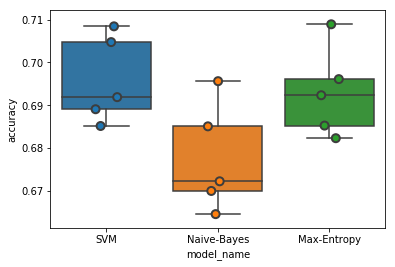

In [45]:
# Training and Cross Validation
fold=5
cv_df=cross_validation(X_train,y_train, fold)

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [46]:
print('Training/Cross validation average accuracies: ')
cv_df.groupby('model_name').accuracy.mean()

Training/Cross validation average accuracies: 


model_name
Max-Entropy    0.692990
Naive-Bayes    0.677515
SVM            0.695867
Name: accuracy, dtype: float64

#### Testing the best model

In [47]:
model=OneVsRestClassifier(svm_pipeline)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc=accuracy_score(y_test, y_pred)
print('Test Accuracy: ', acc)
print('\n\n')
print(metrics.classification_report(y_test, y_pred, target_names=category_df.character.values))

Test Accuracy:  0.697934595524957



              precision    recall  f1-score   support

     BRADLEY       0.59      0.68      0.63        38
   CHRISTIAN       0.52      0.42      0.47        40
       CLARE       0.83      0.67      0.74        45
        DAWN       0.60      0.62      0.61        24
       GARRY       0.70      0.50      0.58        42
     HEATHER       0.72      0.56      0.63        50
         IAN       0.76      0.74      0.75       112
        JACK       0.59      0.75      0.66        52
        JANE       0.82      0.91      0.87        67
         MAX       0.74      0.71      0.72        79
       MINTY       0.60      0.69      0.64        42
       PEGGY       0.57      0.64      0.61        36
        PHIL       0.65      0.68      0.67        60
      RONNIE       0.58      0.56      0.57        52
        ROXY       0.51      0.52      0.52        42
        SEAN       0.73      0.72      0.72        60
     SHIRLEY       0.68      0.67      0.68 

#### Confusion Matrix

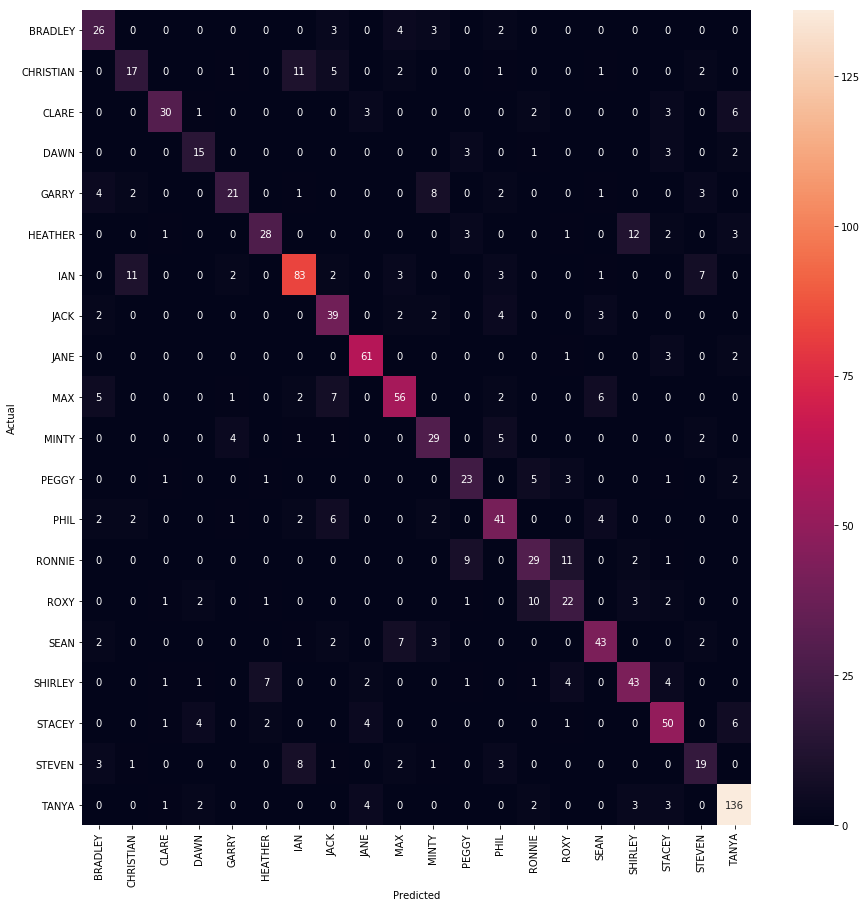

In [48]:
#Plotting the classifiaction matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_df.character.values, yticklabels=category_df.character.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()